# Setup Python Environment
The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.10.0-rc1
print("done")

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
done


# Train Neural Network
## Parse and prepare the data
The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Ftrl
from tensorflow.keras.layers import Dropout

import time

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run

2023-02-28 09:25:44.595240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 09:25:44.657771: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 09:25:44.675957: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-28 09:25:45.038205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

TensorFlow version = 2.10.0-rc1



In [3]:
# SEED = 1337
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

# SEED=int(time.time())
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("../data/own-csv"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()

print(CLASSES)

['box_better', 'laptop-better', 'pc_better', 'phone_better', 'printer', 'printer_better']


In [4]:
NUM_CLASSES = len(CLASSES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

SAMPLES_PER_CLASS = 10 

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("../data/own-csv/" + objectClass + ".csv") #, parse_dates=['timestamp']
  df = df.drop(columns=['time'])
  df = df.drop(columns=['Voltage'])
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_CLASS)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  # for i in range(num_recordings):
  #   tensor = []
  #   row = []
  #   for c in columns:           #columns
  #     row.append(df[c][i])
  #   tensor += row
  #   inputs.append(tensor)
  #   outputs.append(output)
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_CLASS):
        index = i * SAMPLES_PER_CLASS + j
        tensor += [
            df['ApparentPower'][index],
            df['Current'][index],
            df['Factor'][index],
            df['Power'][index],
            df['ReactivePower'][index],        
        ]
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
num_inputs_2 = len(inputs)
print(CLASSES)
print(inputs[0])
print(outputs)
print(num_inputs_2)

# print("Data set parsing and preparation complete.")
# startTimestamp = df['timestamp'].iloc[0]
# endTimestamp = df['timestamp'].iloc[-1]
# print(endTimestamp - startTimestamp)


box_better class will be output 0 of the classifier
49 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

laptop-better class will be output 1 of the classifier
55 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

pc_better class will be output 2 of the classifier
54 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

phone_better class will be output 3 of the classifier
84 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

printer class will be output 4 of the classifier
5989 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

printer_better class will be output 5 of the classifier
51 samples captured for training with inputs ['ApparentPower', 'Current', 'Factor', 'Power', 'ReactivePower'] 

['box_bet

In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_test)
print(num_inputs)

Data set randomization and splitting complete.
[[10.     0.045  0.4   ...  0.41   4.     9.   ]
 [10.     0.044  0.38  ...  0.38   4.     9.   ]
 [10.     0.044  0.4   ...  0.41   4.     9.   ]
 ...
 [10.     0.047  0.37  ...  0.38   4.     9.   ]
 [10.     0.044  0.4   ...  0.4    4.     9.   ]
 [ 9.     0.039  0.55  ...  0.53   7.    11.   ]]
6282


# Test code voor de tijd in de csv om te zetten

#Build & Train the Model
Build and train a TensorFlow model using the high-level Keras API.

In [6]:
# https://www.kaggle.com/getting-started/174307
from sklearn.metrics import accuracy_score

class Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X = X_val
        self.y = y_val.argmax(axis=1)
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0:
            return
        if epoch%10==0: #Hier aanpassan na hoeveel epochs je wilt zien
            pred = (model.predict(self.X))
            print('epoch: ',epoch, ' | loss: ', str(logs['loss']), '| val_loss: ', str(logs['val_loss']), '| accuracy: ', accuracy_score(self.y,pred.argmax(axis=1)))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10) # early stopping -> will sotp training if no improvement for 10 epochs
# build the model and train it
model = tf.keras.Sequential()
# model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance (50
model.add(Dropout(0.25))
model.add(tf.keras.layers.Dense(30, activation='relu')) #30
model.add(Dropout(0.25))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(Dropout(0.25))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae']) # ook adam ke proberen kan zijn dat het netwerk hiermee beter leert
# model.compile(optimizer='ftrl', loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=3000, batch_size=8, validation_data=(inputs_validate, outputs_validate), callbacks=[Callback(inputs_validate, outputs_validate)], verbose=0)
model.summary()

2023-02-28 09:25:46.639599: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-28 09:25:46.639617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: b1154ec67e81
2023-02-28 09:25:46.639621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: b1154ec67e81
2023-02-28 09:25:46.639659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-02-28 09:25:46.639669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-02-28 09:25:46.639672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.78.1
2023-02-28 09:25:46.640006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

40/40 [==============================] - 0s 528us/step
epoch:  10  | loss:  0.015226559713482857 | val_loss:  0.014850172214210033 | accuracy:  0.9554494828957836
40/40 [==============================] - 0s 471us/step
epoch:  20  | loss:  0.014920353889465332 | val_loss:  0.014850173145532608 | accuracy:  0.9554494828957836
40/40 [==============================] - 0s 501us/step
epoch:  30  | loss:  0.014787527732551098 | val_loss:  0.014850173145532608 | accuracy:  0.9554494828957836
40/40 [==============================] - 0s 407us/step
epoch:  40  | loss:  0.014769621193408966 | val_loss:  0.014850173145532608 | accuracy:  0.9554494828957836
40/40 [==============================] - 0s 375us/step
epoch:  50  | loss:  0.014776233583688736 | val_loss:  0.014850173145532608 | accuracy:  0.9554494828957836
40/40 [==============================] - 0s 384us/step
epoch:  60  | loss:  0.014769651927053928 | val_loss:  0.014850173145532608 | accuracy:  0.9554494828957836
40/40 [===============

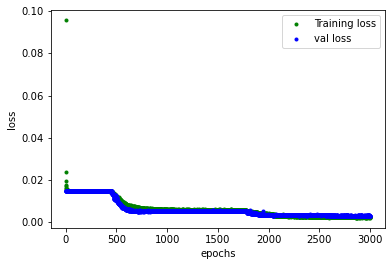

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g.', label="Training loss")
plt.plot(epochs, val_loss, 'b.', label="val loss")

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#Run with Test Data
Put our test data into the model and plot the predictions

40/40 [==============================] - 0s 432us/step
predictions =
 [[0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 ...
 [0.    0.    0.    0.    0.998 0.002]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.001 0.012 0.987 0.    0.   ]]
actual =
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]
[[0.90909091 0.         0.         0.         0.         0.        ]
 [0.09090909 0.84210526 0.         0.         0.         0.        ]
 [0.         0.10526316 1.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.99580185 0.        ]
 [0.         0.05263158 0.         0.         0.00419815 1.        ]]


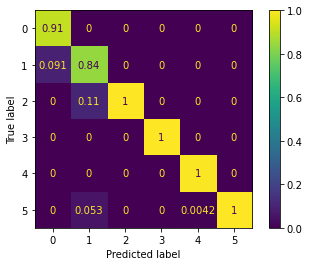

In [8]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# sns.regplot(outputs_test, predictions)
#Predict
y_prediction = np.argmax(predictions, axis = 1)

y_test=np.argmax(outputs_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
disp =  ConfusionMatrixDisplay(confusion_matrix=result)
print(result)
disp.plot()
# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
# plt.plot(inputs_test, predictions, 'r.', label='Predicted')
# plt.show()

In [9]:
# array_test = [[33., 0.152, 0.83, 27., 18.]]
array_test = [[55.,     0.25,   0.93,  51.,    20.,    52.,     0.239,  1.,    52.,     0.,
 54.,     0.247,  0.96,  52.,    15.,    40.,     0.184,  1.,    40.,    0.,
 35.,     0.158,  0.87, 30.,    17.,    35.,     0.157,  0.77,  26.,    22.,
 32.,     0.146,  0.9,   29.,    14.,    33.,     0.149,  0.84,  28.,    18.,
 31.,     0.143,  0.88,  28.,    15.,    32.,     0.147,  0.79,  26.,    20.   ]]
pred_test = model.predict(array_test)

print(pred_test)
class_index = np.argmax(pred_test)
print(class_index)
print(CLASSES[class_index])

1/1 [==============================] - 0s 22ms/step
[[0. 1. 0. 0. 0. 0.]]
1
laptop-better


In [10]:
model.save('model_saved/')

INFO:tensorflow:Assets written to: model_saved/assets


In [11]:
!tar chvfz notebook.tar.gz *

classification_device.ipynb
model_saved/
model_saved/keras_metadata.pb
model_saved/saved_model.pb
model_saved/assets/
model_saved/variables/
model_saved/variables/variables.index
model_saved/variables/variables.data-00000-of-00001
notebook.tar.gz
